In [267]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statistics
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer

import warnings
warnings.simplefilter('ignore')

In [296]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result
"""Multivariate Time Series"""
occ_data = pd.read_csv('stock\MSFT_Stock.csv')
# occ_data.Date = pd.to_datetime(occ_data.Date)
# occ_data = occ_data.set_index('Date')
occ_data.head()

,Unnamed: 0,open,high,low,close,volume
0,2001-03-16,26.25000,27.56250,26.24219,27.28125,112848800
1,2001-03-19,27.25000,27.75000,26.56250,27.15625,61036400
2,2001-03-20,27.28125,28.06250,26.31250,26.34375,91822800
3,2001-03-21,26.12500,26.62500,24.87500,25.03125,124988600
4,2001-03-22,25.28125,27.03125,25.25000,27.00000,126363200


In [297]:
date = occ_data["Unnamed: 0"]
occ_data.drop("Unnamed: 0", axis =1 ,inplace =True)

In [298]:
for col in occ_data.columns:
    if len(occ_data[col].value_counts()) <50:
        occ_data.drop(col, axis = 1 , inplace = True)
    elif not np.issubdtype(occ_data[col].dtype, np.number):
        occ_data[col] = pd.to_numeric(occ_data[col], errors='coerce')

In [299]:
imputer = KNNImputer(n_neighbors=5)
knn = imputer.fit(occ_data)
occ_data=pd.DataFrame(knn.transform(occ_data),columns=occ_data.columns)
temp  =occ_data
occ_data=StandardScaler().fit_transform(temp)
occ_data = pd.DataFrame(occ_data, index=temp.index, columns=temp.columns)
# occ_data.dropna(inplace= True )
# occ_data.isna().sum()

In [300]:
occ_data['Date'] = date

In [301]:
# Convert to datetime
occ_data.Date = pd.to_datetime(occ_data.Date)
# Set Index
occ_data = occ_data.set_index('Date')
# Convert to freq
# df = df.asfreq(pd.infer_freq(df.index))

In [302]:
adf_test_results = {
    col: test_stationarity(occ_data, col)
    for col in occ_data.columns
}
adf_test_results


{'open': 'Non-Stationary',
 'high': 'Non-Stationary',
 'low': 'Non-Stationary',
 'close': 'Non-Stationary',
 'volume': 'Stationary'}

Need the next 2 block only if the data is  "non Stationary"

In [303]:
# Making the data stationary
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in occ_data.columns:
    occ_data[col] = differencing(occ_data, col, 1)


In [304]:
month_mean_train = occ_data.groupby(occ_data.index.month).mean()
# Removing the long term seasonality from train
for col in occ_data.columns:
    occ_data[col] = occ_data.apply(lambda x: x[col] - month_mean_train[col][x.name.month], axis=1)

In [305]:
adf_test_results = {
    col: test_stationarity(occ_data, col)
    for col in occ_data.columns
}
adf_test_results


{'open': 'Stationary',
 'high': 'Stationary',
 'low': 'Stationary',
 'close': 'Stationary',
 'volume': 'Stationary'}

In [306]:
# occ_data= np.abs(occ_data)

In [307]:
max_lag = 20
var_model = VAR(occ_data)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag) 

20


In [308]:
def find_anomalies(squared_errors):
    threshold = np.percentile(squared_errors, 99.2)#np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold
var = VAR(occ_data)
var_fitresults = var.fit(selected_lag)
squared_errors = var_fitresults.resid.sum(axis=1) ** 2
predictions, threshold = find_anomalies(squared_errors) 

In [309]:
data = occ_data.iloc[selected_lag:, :]
data['Predictions'] = predictions.values
data

,open,high,low,close,volume,Predictions
Date,,,,,,
2001-04-16,0.017351,-0.010853,0.005708,-0.018426,-0.786973,0
2001-04-17,-0.013000,0.003059,-0.003886,0.004778,0.563592,0
2001-04-18,0.028844,0.043581,0.030426,0.041146,2.286834,0
2001-04-19,0.023823,0.026909,0.028056,0.026197,0.015754,0
2001-04-20,0.046921,0.020394,0.028056,0.007790,1.033591,0
...,...,...,...,...,...,...
2021-01-25,0.043829,-0.008270,-0.036941,0.078398,0.037698,0
2021-01-26,0.059451,0.095299,0.131006,0.060995,0.450571,0
2021-01-27,0.135329,0.136374,0.000080,0.011239,0.632315,0


In [310]:
data['Predictions'].value_counts()

0    4940
1      40
Name: Predictions, dtype: int64

In [311]:
from datetime import datetime

In [312]:
data[:-1]

,open,high,low,close,volume,Predictions
Date,,,,,,
2001-04-16,0.017351,-0.010853,0.005708,-0.018426,-0.786973,0
2001-04-17,-0.013000,0.003059,-0.003886,0.004778,0.563592,0
2001-04-18,0.028844,0.043581,0.030426,0.041146,2.286834,0
2001-04-19,0.023823,0.026909,0.028056,0.026197,0.015754,0
2001-04-20,0.046921,0.020394,0.028056,0.007790,1.033591,0
...,...,...,...,...,...,...
2021-01-22,0.051417,0.081387,0.075024,0.020387,-0.081406,0
2021-01-25,0.043829,-0.008270,-0.036941,0.078398,0.037698,0
2021-01-26,0.059451,0.095299,0.131006,0.060995,0.450571,0


In [313]:
anomalies = data[data.Predictions == 1]
anomalies.shape, anomalies.head()

((40, 6),
                 open      high       low     close    volume  Predictions
 Date                                                                     
 2001-09-21 -0.048278 -0.021231 -0.034767 -0.010903  2.188351            1
 2002-10-17  0.019306  0.012016 -0.004173  0.002652  2.855276            1
 2003-01-17 -0.039413 -0.042167 -0.044164 -0.044875  2.394842            1
 2003-10-24 -0.034143 -0.038774 -0.039501 -0.052681  4.703171            1
 2004-04-23  0.038999  0.035411  0.039229  0.032556  5.172811            1)

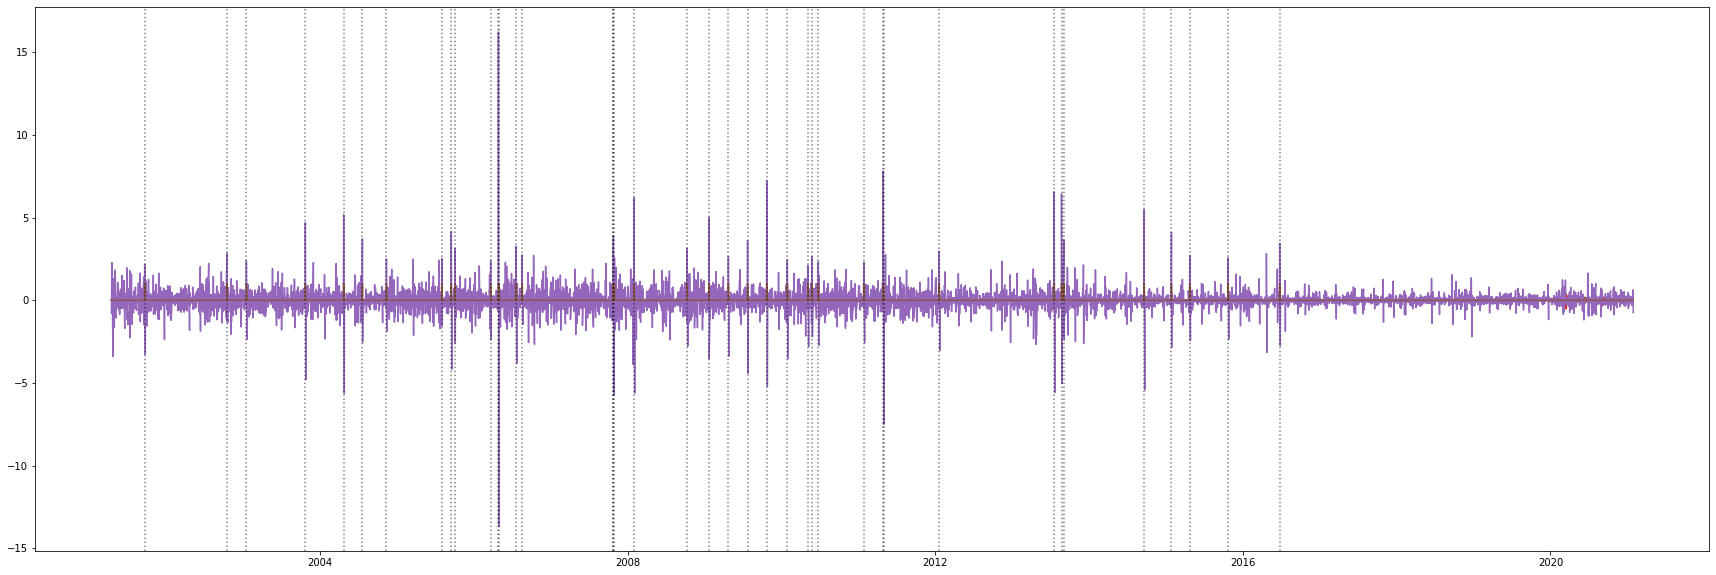

In [314]:
plt.figure(figsize=(30,10))
plt.plot(data[:-1])
for year in anomalies.index:
    plt.axvline(datetime(year.to_pydatetime().year,year.to_pydatetime().month,year.to_pydatetime().day), color='k', linestyle=':', alpha=0.5)
# for year in range(2014,2020):
#     plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)